#Import library

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest #feature selection
from sklearn.feature_selection import chi2
from sklearn.utils import resample #re-sampling
from sklearn.model_selection import train_test_split #data splitting
from sklearn.preprocessing import StandardScaler #normalize features

from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier #decision tree
from sklearn.ensemble import RandomForestClassifier #random forest
import xgboost as xgb #xgboost
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score #roc score

# Read data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Internship/Rakamin X Home Credit Indonesia/home credit dataset/application_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Internship/Rakamin X Home Credit Indonesia/home credit dataset/application_test.csv')

In [ ]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


#EDA

In [ ]:
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [ ]:
train = df_train.copy()

### Univariate: The Number of Customers Based on Their Repayment Abilities

In [ ]:
decode_map = {0: "No Payment Difficulties", 1: "Payment Difficulties"}
def decode_sentiment(label):
  return decode_map[int(label)]

train['TARGET'] = train['TARGET'].apply(lambda x: decode_sentiment(x))

In [ ]:
target_grp = (train[['TARGET']]
                .groupby("TARGET")
                .agg(COUNT=("TARGET","count"))
                .sort_values(by=["COUNT"],ascending=False)
                .reset_index()
                )

target_grp.style.background_gradient(cmap='Blues')

,TARGET,COUNT
0,No Payment Difficulties,282686
1,Payment Difficulties,24825


In [ ]:
#normalization
grp = train['TARGET'].value_counts(normalize=True)
grp.reset_index().style.background_gradient(cmap='Blues')

,index,TARGET
0,No Payment Difficulties,0.919271
1,Payment Difficulties,0.080729


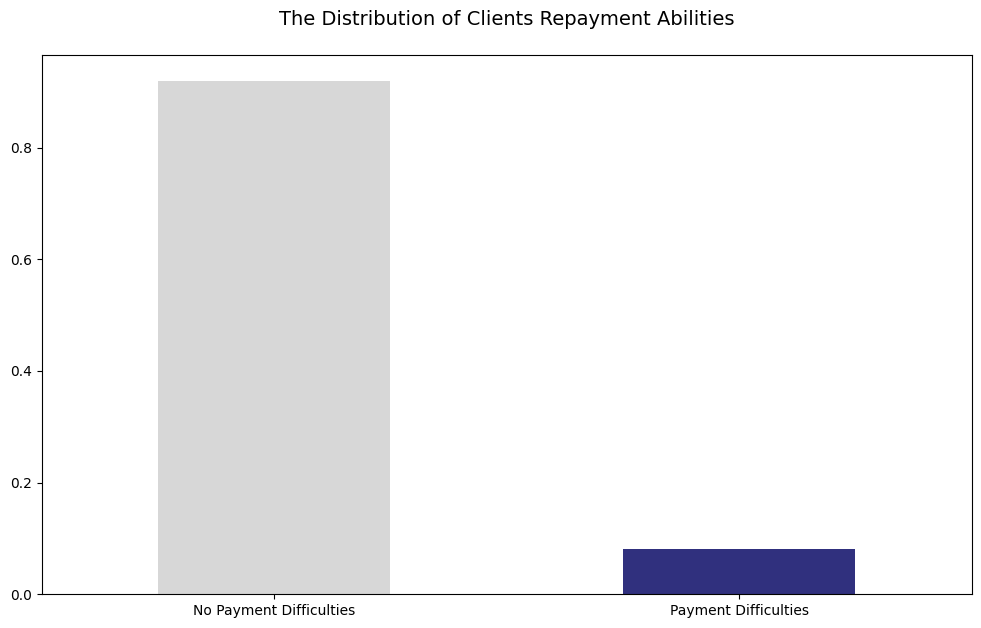

In [ ]:
fig = plt.figure(figsize = (12,7))
grp.plot(kind='bar', color= ['lightgrey','midnightblue'], alpha = 0.9, rot=0)
plt.title('The Distribution of Clients Repayment Abilities\n', fontsize=14)
plt.show()

There are about 91% loans which is equal to about 282K with TARGET = 0, which indicates that client did not had any problems in repaying the loan in given time. While only 9% of the total loans (about 24K applicants) in this dataset involved the clients having problems in repaying the loan.

Note: This dataset is imbalanced and it does require special treatment or resampling. The resampling step will be carried out in the model building section.

### Bivariate: Numerical Features Vs Target

**Age vs Target**

In [ ]:
no_age = df_train[df_train['TARGET']==0]['DAYS_BIRTH'].values/-365
yes_age = df_train[df_train['TARGET']==1]['DAYS_BIRTH'].values/-365

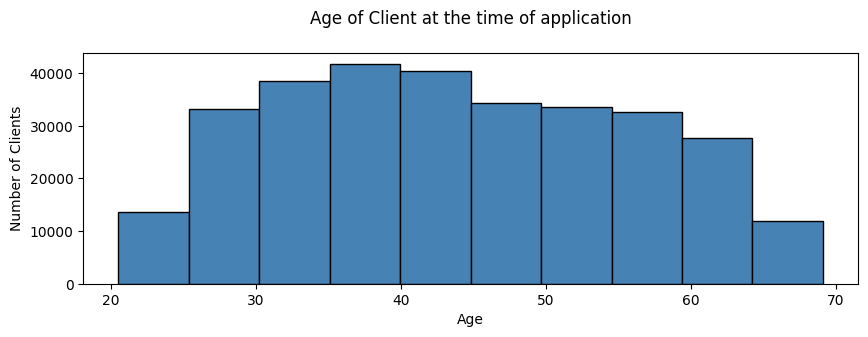

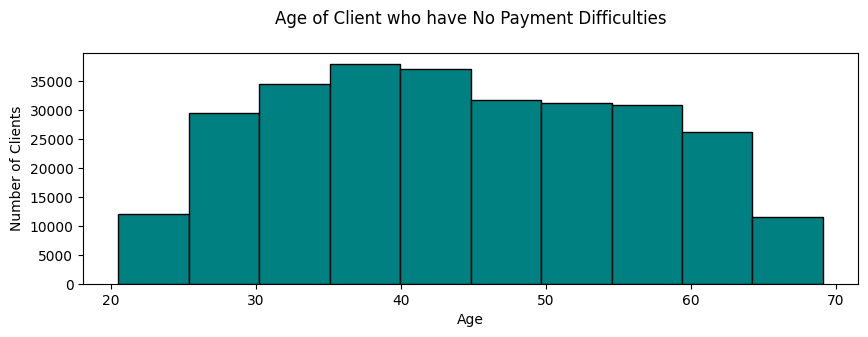

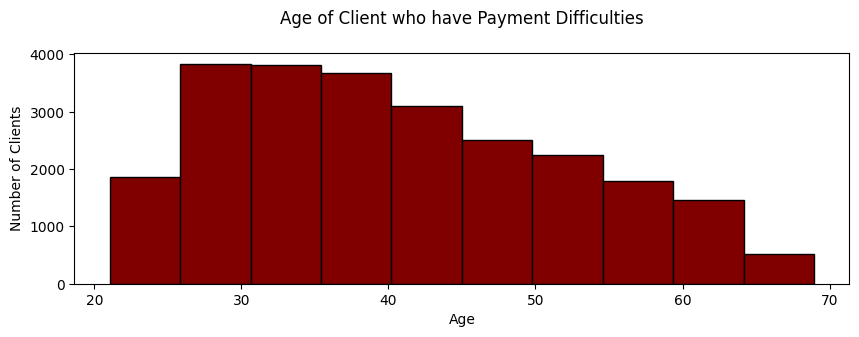

In [ ]:

plt.figure(figsize=(10,3))
plt.hist(df_train['DAYS_BIRTH'].values/-365, bins=10, edgecolor='black', color='steelblue')
plt.title('Age of Client at the time of application\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(no_age, bins=10, edgecolor='black', color='teal')
plt.title('Age of Client who have No Payment Difficulties\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(yes_age, bins=10, edgecolor='black', color='maroon')
plt.title('Age of Client who have Payment Difficulties\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

Most number of clients who apply for loans are in the range of 35-40 years, followed by clients in the range of 40-45 years. Meanwhile, the number of applicants for clients aged <25 or age >65 is very low.

Clients who have no payment difficulties are client the range of 35-45 years. While clients who have payment difficulties are client the range of 25-35 years.

### Multivariat

**Grouped by Contract Type**

1. Income Type, Amount of Credit, Target, and Contract Type

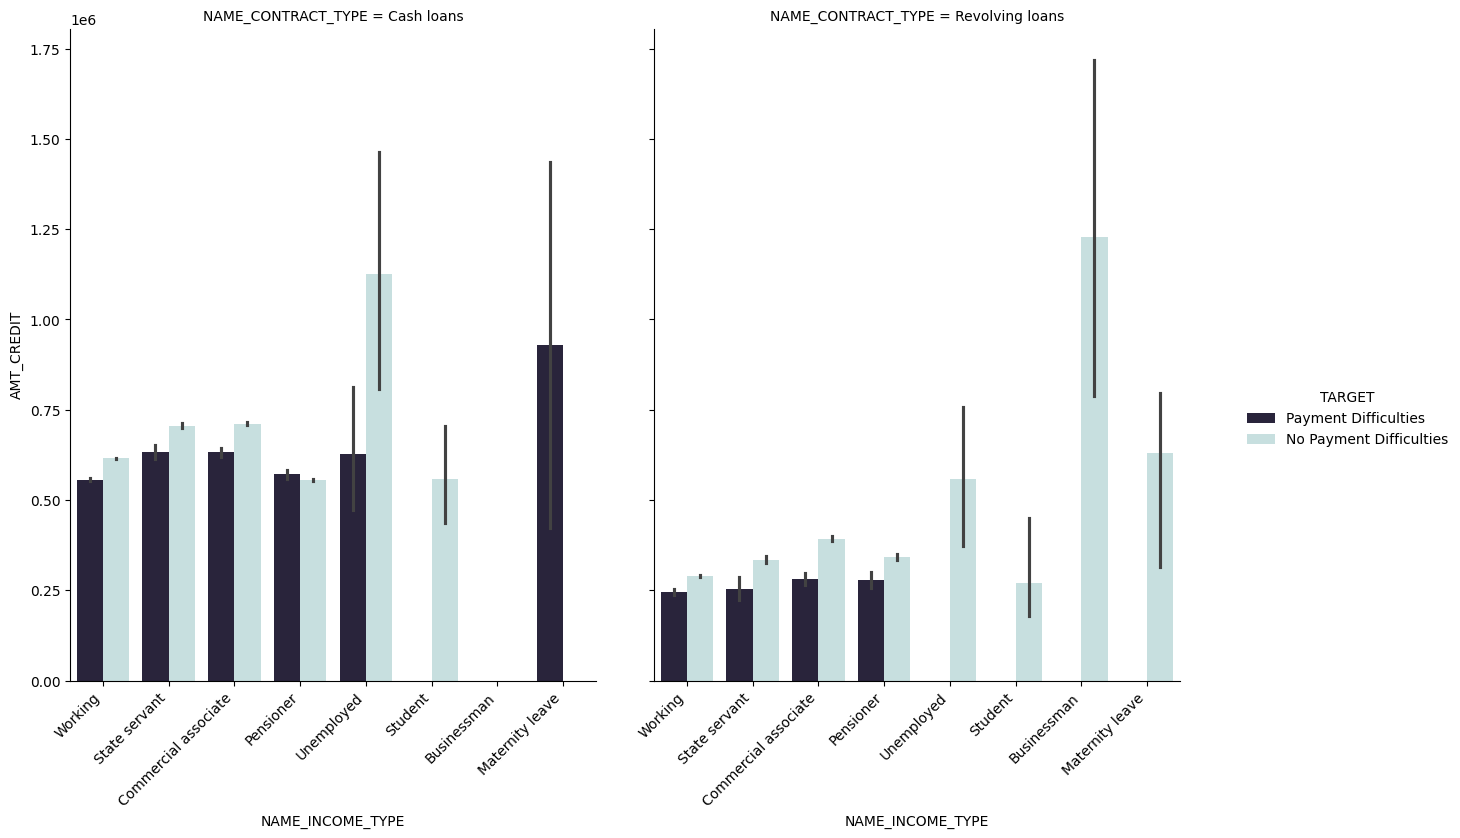

In [ ]:
fig = sns.catplot(x = 'NAME_INCOME_TYPE',
            y = 'AMT_CREDIT',
            hue = 'TARGET',
            col = 'NAME_CONTRACT_TYPE',
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.gcf().set_size_inches(15, 8)
plt.show()

For the income type of maternity leave with cash loans, all the clients have problems repaying the loans for a medium credit amount of the loan. While all clients with maternity leaves and revolving loans have no difficulty repaying the loans.

For unemployed clients with cash loans, more than 50% of clients have problems repaying loans with medium credit amounts of the loan. While all unemployed clients with revolving loans have no difficulty repaying the loan.

All student clients have no difficulty repaying the loans either with cash loan or revolving loan for a low to medium credit amount of the loan.

**Grouped by Rating of Region where Client Lives**

1. Housing Type, Amount Credit of Loan, Target, and Rating of Region where Client Lives

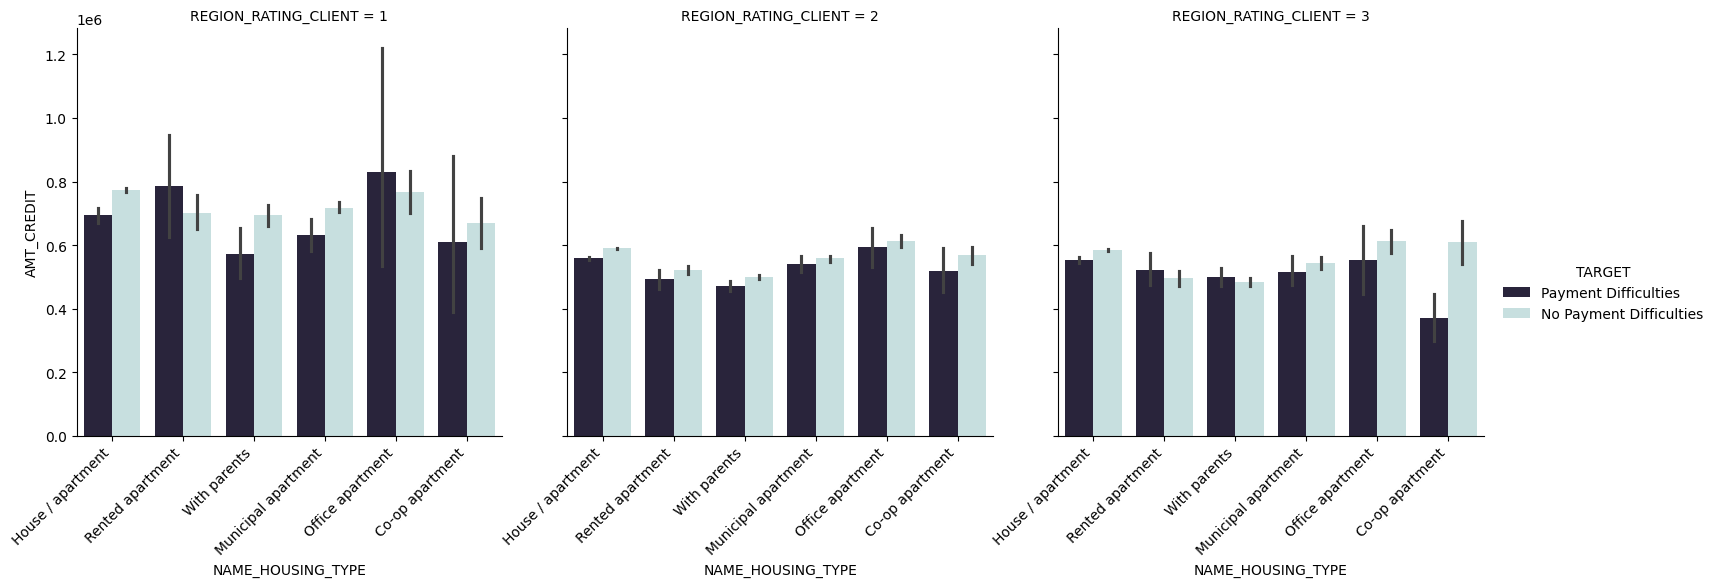

In [ ]:
fig = sns.catplot(x = 'NAME_HOUSING_TYPE',
            y = 'AMT_CREDIT',
            hue = 'TARGET',
            col = 'REGION_RATING_CLIENT',
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

Clients who lives in rented apartment and office apartment and their region have a rating of 1, have a problem repaying the loans compared to client in region with rating of 2 for a medium credit amount of the loan.

2. Education Type, Amount Credit of Loan, Target, and Rating of Region where Client Lives

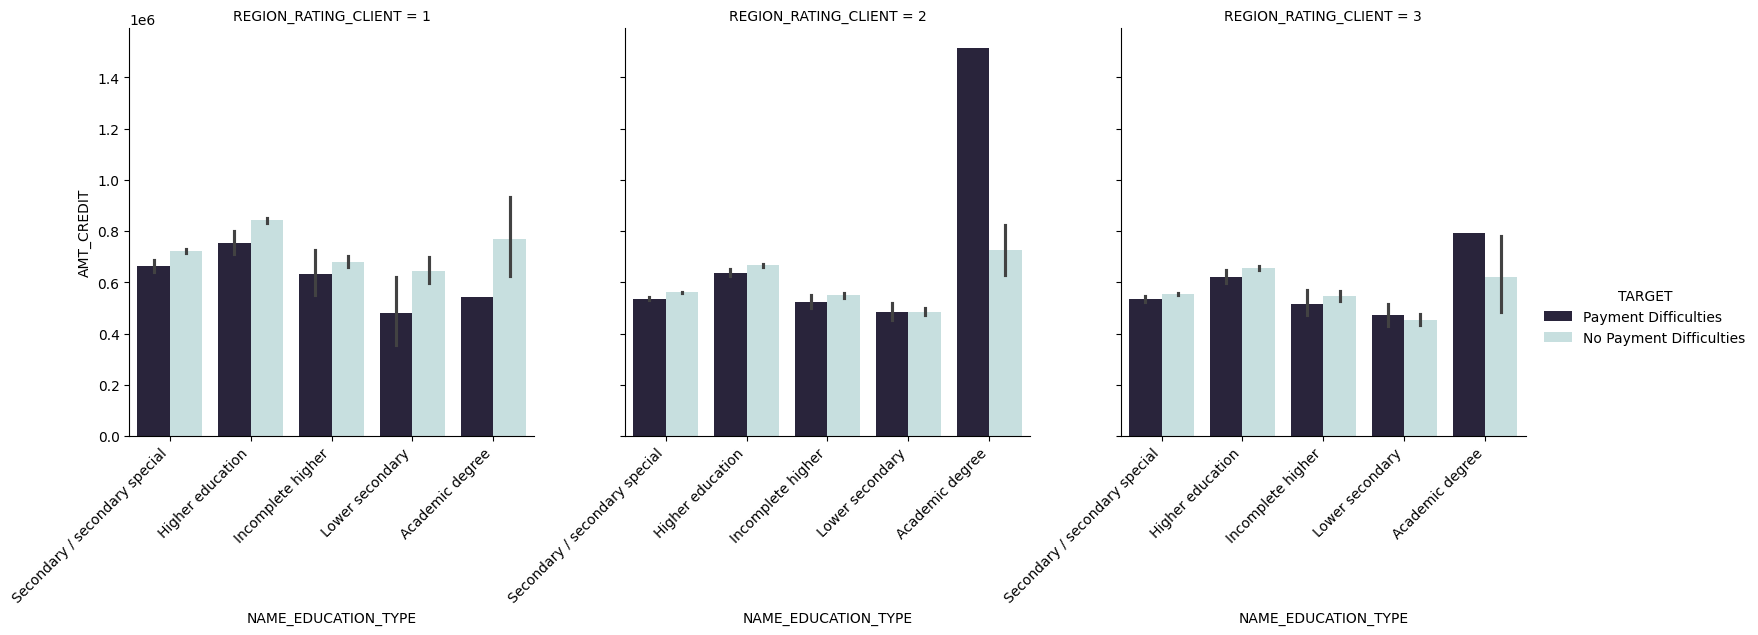

In [ ]:
fig = sns.catplot(x = 'NAME_EDUCATION_TYPE',
            y = 'AMT_CREDIT',
            hue = 'TARGET',
            col = 'REGION_RATING_CLIENT',
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

3. Family Status, Amount Credit of Loan, Target, and Rating of Region where Client Lives

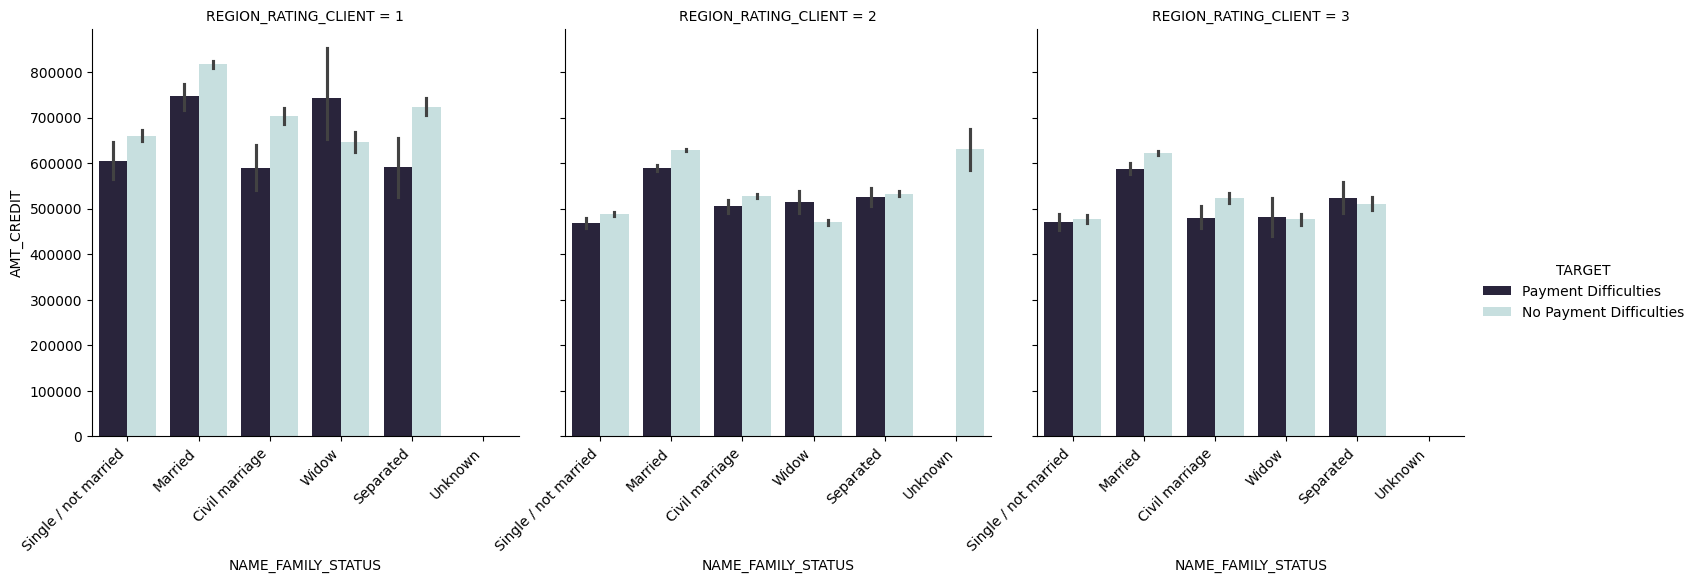

In [ ]:
fig = sns.catplot(x = 'NAME_FAMILY_STATUS',
            y = 'AMT_CREDIT',
            hue = 'TARGET',
            col = 'REGION_RATING_CLIENT',
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

# Data Cleaning

Check duplicated data

In [ ]:
df_train.duplicated().sum()

0

Check missing values

In [ ]:
count_nv = pd.DataFrame(df_train.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nv['Percentage'] = ( count_nv['Total Null Data'] / len(df_train) ) * 100
count_nv[count_nv['Percentage'] > 40].sort_values(by='Percentage', ascending=False)

,index,Total Null Data,Percentage
48,COMMONAREA_AVG,214865,69.872297
76,COMMONAREA_MEDI,214865,69.872297
62,COMMONAREA_MODE,214865,69.872297
84,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
70,NONLIVINGAPARTMENTS_MODE,213514,69.432963
56,NONLIVINGAPARTMENTS_AVG,213514,69.432963
86,FONDKAPREMONT_MODE,210295,68.386172
82,LIVINGAPARTMENTS_MEDI,210199,68.354953
54,LIVINGAPARTMENTS_AVG,210199,68.354953
68,LIVINGAPARTMENTS_MODE,210199,68.354953


we will remove the feature that have more than 40% null data

In [ ]:
data = list(count_nv[count_nv['Percentage'] > 40]['index'])
df = df_train.drop(columns = data)
df = df_train.drop(columns = 'SK_ID_CURR')

In [ ]:
count_nv = pd.DataFrame(df_train.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nv['Percentage'] = ( count_nv['Total Null Data'] / len(df_train) ) * 100
still_null = count_nv[count_nv['Percentage'] != 0].sort_values(by='Percentage', ascending=False)

In [ ]:
a = list(still_null['index'])
df_train[a].dtypes

for i in a:
    data = df_train[i]
    types = str(data.dtype)
    if types == 'object':
        df_train[i].fillna(df_train[i].mode()[0], inplace=True)
    else:
        df_train[i].fillna(df_train[i].median(), inplace=True)

Check for missing values again

In [ ]:
count_nv = pd.DataFrame(df_train.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nv['Percentage'] = ( count_nv['Total Null Data'] / len(df_train) ) * 100
count_nv[count_nv['Percentage'] > 0].sort_values(by='Percentage', ascending=False)

,index,Total Null Data,Percentage


Replace unknown value

In [ ]:
df['CODE_GENDER'] = df['CODE_GENDER'].replace(['XNA'], df['CODE_GENDER'].mode()[0])
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(['XNA'], df['ORGANIZATION_TYPE'].mode()[0])

# ML Models

### Label Encoding

In [ ]:
df_train[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY",
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]] = df_train[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY",
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]].apply(LabelEncoder().fit_transform)


In [ ]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Handling Imbalanced Data

In [ ]:
# creat two different dataframe of majority and minority class
df_majority = df_train[(df_train['TARGET']==0)]
df_minority = df_train[(df_train['TARGET']==1)]

In [ ]:
# upsample minority class
df_minority_unsampled = resample(df_minority,
                                 replace=True, # sample with replacement
                                 n_samples=282686, # to match majority class
                                 random_state=42) # reproducible results

In [ ]:
# combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_unsampled, df_majority])

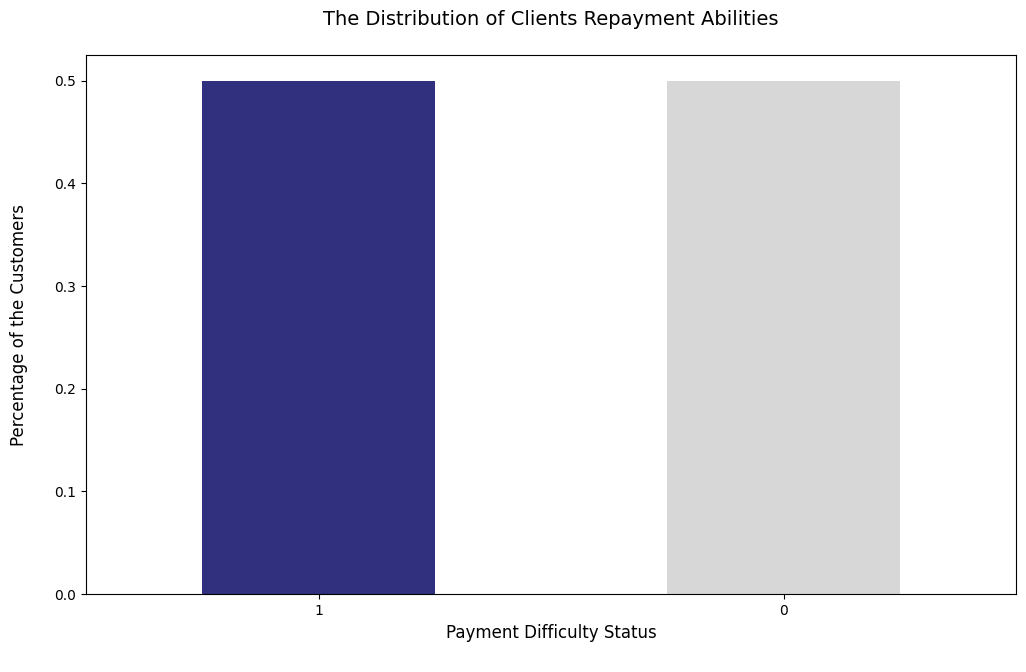

In [ ]:
# visualization
fig = plt.figure(figsize = (12,7))
df_upsampled['TARGET'].value_counts(normalize=True).plot(kind='bar', color=['midnightblue','lightgrey'], alpha = 0.9, rot = 0)
plt.title('The Distribution of Clients Repayment Abilities\n', fontsize=14)
plt.ylabel('Percentage of the Customers\n', fontsize=12)
plt.xlabel('Payment Difficulty Status\n', fontsize=12)
plt.show()

### Data Splitting

In [ ]:
# define x and y features (top 20 features)
x_balanced = df_upsampled[['DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'AMT_CREDIT',
                           'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION',
                           'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY',
                           'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REG_CITY_NOT_WORK_CITY',
                          'CODE_GENDER', 'EXT_SOURCE_2', 'REG_CITY_NOT_LIVE_CITY', 'NAME_EDUCATION_TYPE',
                          'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_3', 'DEF_60_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY']]
y_balanced = df_upsampled['TARGET']

In [ ]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(x_balanced,
                                                    y_balanced,
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape, X_test.shape)

(452297, 20) (113075, 20)


In [ ]:
# normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Model Building

Here are some algorithms that will be tested:
1.  Logistic Regression
2.  Decision Tree
3.  Random Forest
4.  XGBoost



#### 1. Logistic Regression

In [ ]:
# train the model
log_model = LogisticRegression().fit(X_train, y_train)
print(log_model)

LogisticRegression()


In [ ]:
# predict data train
y_train_pred_log = log_model.predict(X_train)

In [ ]:
# print classification report
print('Classification Report Training Model (Logistic Regression):')
print(classification_report(y_train, y_train_pred_log))

Classification Report Training Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68    226185
           1       0.68      0.66      0.67    226112

    accuracy                           0.67    452297
   macro avg       0.67      0.67      0.67    452297
weighted avg       0.67      0.67      0.67    452297



In [ ]:
# form confusion matrix as a DataFrame
confusion_matrix_log = pd.DataFrame((confusion_matrix(y_train, y_train_pred_log)),
                                    ('No Payment Difficulties', 'Payment Difficulties'),
                                    ('No Payment Difficulties', 'Payment Difficulties'))

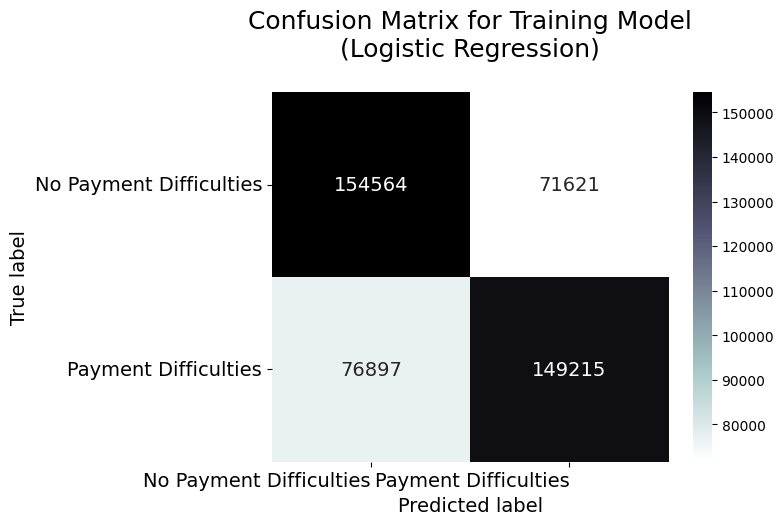

In [ ]:
# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_log, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Logistic Regression)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
# predict data test
y_test_pred_log = log_model.predict(X_test)

In [ ]:
# print classification report
print('Classification Report Testing Model (Logistic Regression):')
print(classification_report(y_test, y_test_pred_log))

Classification Report Testing Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68     56501
           1       0.68      0.66      0.67     56574

    accuracy                           0.67    113075
   macro avg       0.67      0.67      0.67    113075
weighted avg       0.67      0.67      0.67    113075



In [ ]:
# form confusion matrix as a DataFrame
confusion_matrix_log = pd.DataFrame((confusion_matrix(y_test, y_test_pred_log)),
                                    ('No Payment Difficulties', 'Payment Difficulties'),
                                    ('No Payment Difficulties', 'Payment Difficulties'))

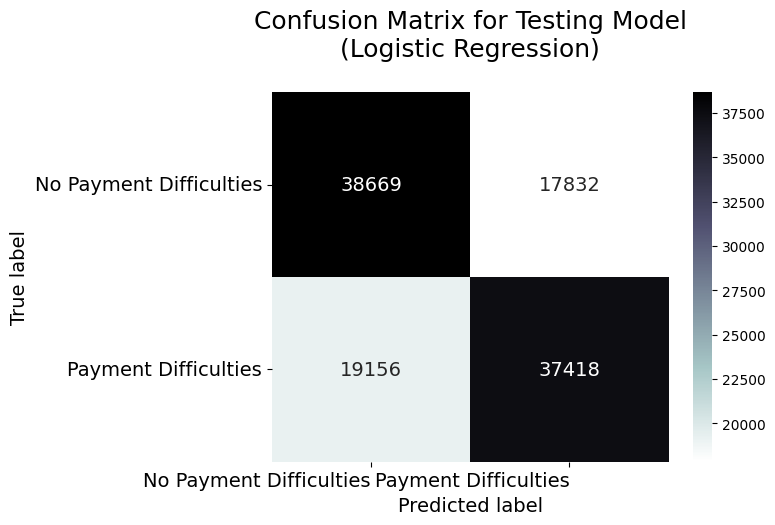

In [ ]:
# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_log, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Logistic Regression)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
acc_log_train=round(log_model.score(X_train,y_train)*100,2)
acc_log_test=round(log_model.score(X_test,y_test)*100,2)
error_log = round(acc_log_test - acc_log_train,2)
print("Training Accuracy: {} %".format(acc_log_train))
print("Testing Accuracy: {} %".format(acc_log_test))
print("Error: {} %".format(abs(error_log)))

Training Accuracy: 67.16 %
Testing Accuracy: 67.29 %
Error: 0.13 %


In [ ]:
# ROC scores
roc_auc_log = round(roc_auc_score(y_test, y_test_pred_log),4)
print('ROC AUC:', roc_auc_log)

ROC AUC: 0.6729


#### 2. Decision Tree

In [ ]:
# train the model
dt_model = DecisionTreeClassifier().fit(X_train, y_train)
print(dt_model)

DecisionTreeClassifier()


In [ ]:
# predict data train
y_train_pred_dt = dt_model.predict(X_train)

In [ ]:
# print classification report
print('Classification Report Training Model (Decision Tree Classifier):')
print(classification_report(y_train, y_train_pred_dt))

Classification Report Training Model (Decision Tree Classifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226185
           1       1.00      1.00      1.00    226112

    accuracy                           1.00    452297
   macro avg       1.00      1.00      1.00    452297
weighted avg       1.00      1.00      1.00    452297



In [ ]:
# form confusion matrix as a DataFrame
confusion_matrix_dt = pd.DataFrame((confusion_matrix(y_train, y_train_pred_dt)),
                                    ('No Payment Difficulties', 'Payment Difficulties'),
                                    ('No Payment Difficulties', 'Payment Difficulties'))

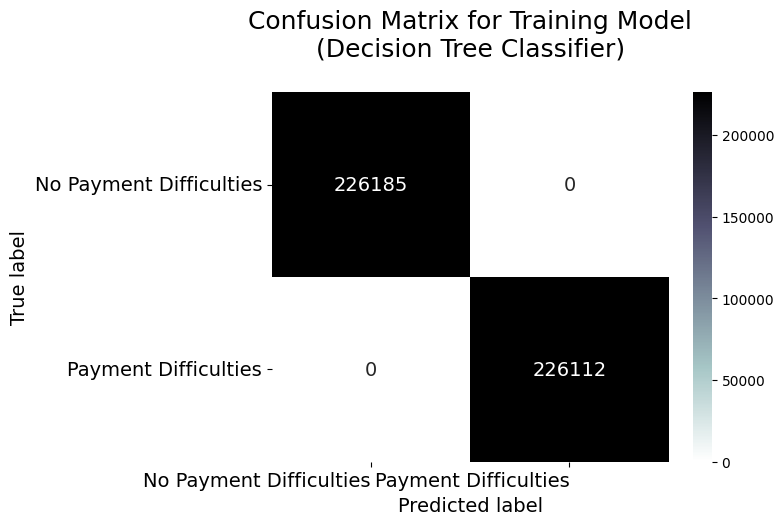

In [ ]:
# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Decision Tree Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
# predict data test
y_test_pred_dt = dt_model.predict(X_test)

In [ ]:
# print classification report
print('Classification Report Testing Model (Decision Tree Classifier):')
print(classification_report(y_test, y_test_pred_dt))

Classification Report Testing Model (Decision Tree Classifier):
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     56501
           1       0.90      0.86      0.88     56574

    accuracy                           0.88    113075
   macro avg       0.88      0.88      0.88    113075
weighted avg       0.88      0.88      0.88    113075



In [ ]:
# form confusion matrix as a dataFrame
confusion_matrix_dt = pd.DataFrame((confusion_matrix(y_test, y_test_pred_dt)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

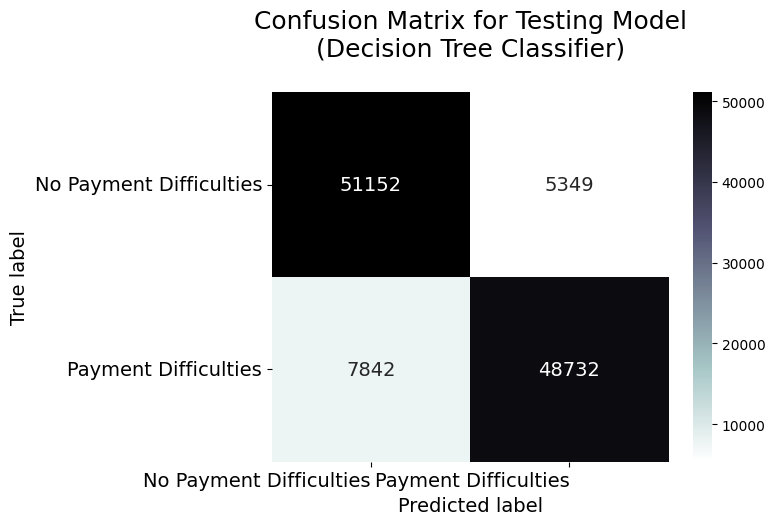

In [ ]:
# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Decision Tree Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
acc_dt_train=round(dt_model.score(X_train,y_train)*100,2)
acc_dt_test=round(dt_model.score(X_test,y_test)*100,2)
error_dt = round(acc_dt_test - acc_dt_train,2)
print("Training Accuracy: {} %".format(acc_dt_train))
print("Testing Accuracy: {} %".format(acc_dt_test))
print("Error: {} %".format(abs(error_dt)))

Training Accuracy: 100.0 %
Testing Accuracy: 88.33 %
Error: 11.67 %


In [ ]:
# ROC scores
roc_auc_dt = round(roc_auc_score(y_test, y_test_pred_dt),4)
print('ROC AUC:', roc_auc_dt)

ROC AUC: 0.8834


#### 3. Random Forest

In [ ]:
# train the model
rf_model = RandomForestClassifier().fit(X_train, y_train)
print(rf_model)

RandomForestClassifier()


In [ ]:
# predict data train
y_train_pred_rf = rf_model.predict(X_train)

In [ ]:
# print classification report
print('Classification Report Training Model (Random Forest):')
print(classification_report(y_train, y_train_pred_rf))

Classification Report Training Model (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226185
           1       1.00      1.00      1.00    226112

    accuracy                           1.00    452297
   macro avg       1.00      1.00      1.00    452297
weighted avg       1.00      1.00      1.00    452297



In [ ]:
# form confusion matrix as a DataFrame
confusion_matrix_rf = pd.DataFrame((confusion_matrix(y_train, y_train_pred_rf)),
                                    ('No Payment Difficulties', 'Payment Difficulties'),
                                    ('No Payment Difficulties', 'Payment Difficulties'))

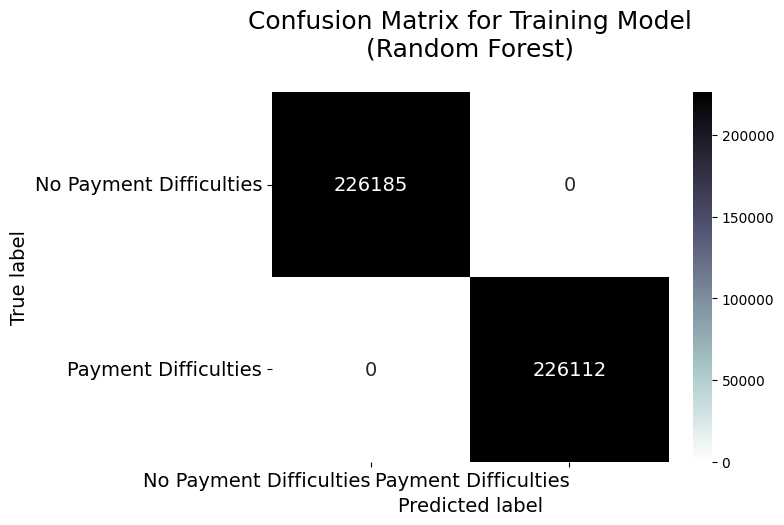

In [ ]:
# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Random Forest)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
# predict data test
y_test_pred_rf = rf_model.predict(X_test)

In [ ]:
# print classification report
print('Classification Report Testing Model (Random Forest):')
print(classification_report(y_test, y_test_pred_rf))

Classification Report Testing Model (Random Forest):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56501
           1       0.99      1.00      1.00     56574

    accuracy                           1.00    113075
   macro avg       1.00      1.00      1.00    113075
weighted avg       1.00      1.00      1.00    113075



In [ ]:
# form confusion matrix as a DataFrame
confusion_matrix_rf = pd.DataFrame((confusion_matrix(y_test, y_test_pred_rf)),
                                    ('No Payment Difficulties', 'Payment Difficulties'),
                                    ('No Payment Difficulties', 'Payment Difficulties'))

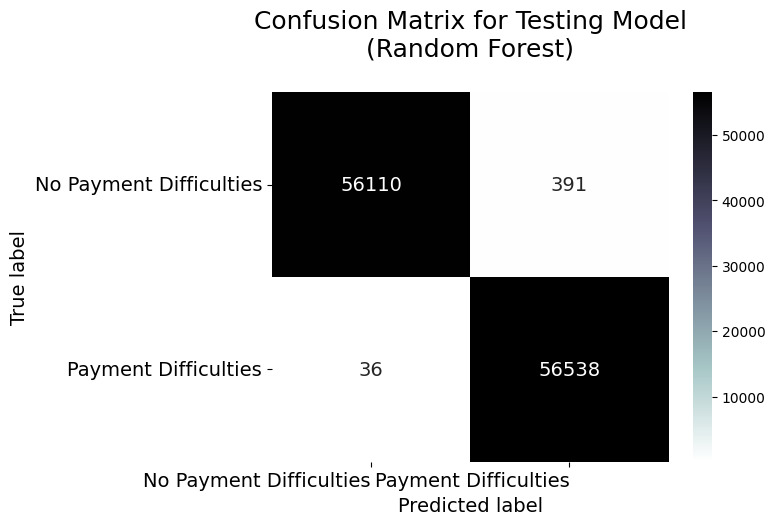

In [ ]:
# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Random Forest)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
acc_rf_train=round(rf_model.score(X_train,y_train)*100,2)
acc_rf_test=round(rf_model.score(X_test,y_test)*100,2)
error_rf = round(acc_rf_test - acc_rf_train,2)
print("Training Accuracy: {} %".format(acc_rf_train))
print("Testing Accuracy: {} %".format(acc_rf_test))
print("Error: {} %".format(abs(error_rf)))

Training Accuracy: 100.0 %
Testing Accuracy: 99.62 %
Error: 0.38 %


In [ ]:
# ROC scores
roc_auc_rf = round(roc_auc_score(y_test, y_test_pred_rf),4)
print('ROC AUC:', roc_auc_rf)

ROC AUC: 0.9962


#### 4. XGBoost

In [ ]:
# train the model
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
print(xgb_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [ ]:
# predict data train
y_train_pred_xgb = xgb_model.predict(X_train)

In [ ]:
# print classification report
print('Classification Report Training Model (XGBoost):')
print(classification_report(y_train, y_train_pred_xgb))

Classification Report Training Model (XGBoost):
              precision    recall  f1-score   support

           0       0.77      0.74      0.75    226185
           1       0.75      0.77      0.76    226112

    accuracy                           0.76    452297
   macro avg       0.76      0.76      0.76    452297
weighted avg       0.76      0.76      0.76    452297



In [ ]:
# form confusion matrix as a DataFrame
confusion_matrix_xgb = pd.DataFrame((confusion_matrix(y_train, y_train_pred_xgb)),
                                    ('No Payment Difficulties', 'Payment Difficulties'),
                                    ('No Payment Difficulties', 'Payment Difficulties'))

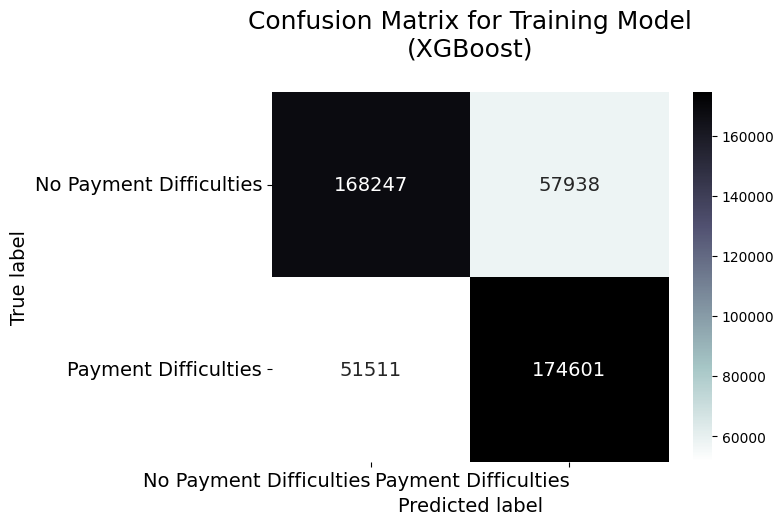

In [ ]:
# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_xgb, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(XGBoost)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
# predict data test
y_test_pred_xgb = xgb_model.predict(X_test)

In [ ]:
# print classification report
print('Classification Report Testing Model (XGBoost):')
print(classification_report(y_test, y_test_pred_xgb))

Classification Report Testing Model (XGBoost):
              precision    recall  f1-score   support

           0       0.68      0.77      0.72     56501
           1       0.73      0.64      0.68     56574

    accuracy                           0.70    113075
   macro avg       0.71      0.70      0.70    113075
weighted avg       0.71      0.70      0.70    113075



In [ ]:
# form confusion matrix as a DataFrame
confusion_matrix_xgb = pd.DataFrame((confusion_matrix(y_test, y_test_pred_xgb)),
                                    ('No Payment Difficulties', 'Payment Difficulties'),
                                    ('No Payment Difficulties', 'Payment Difficulties'))

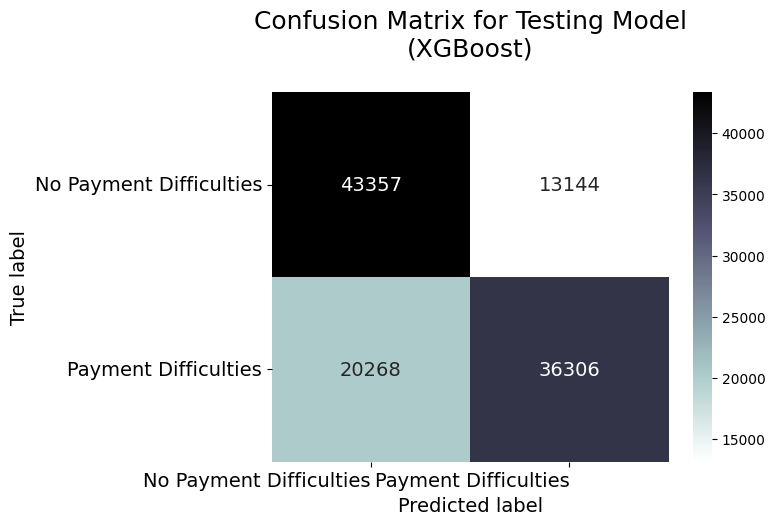

In [ ]:
# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(XGBoost)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
acc_xgb_train=round(xgb_model.score(X_train,y_train)*100,2)
acc_xgb_test=round(xgb_model.score(X_test,y_test)*100,2)
error_xgb = round(acc_xgb_test - acc_xgb_train,2)
print("Training Accuracy: {} %".format(acc_xgb_train))
print("Testing Accuracy: {} %".format(acc_xgb_test))
print("Error: {} %".format(abs(error_xgb)))

Training Accuracy: 75.8 %
Testing Accuracy: 70.45 %
Error: 5.35 %


In [ ]:
# ROC scores
roc_auc_xgb = round(roc_auc_score(y_test, y_test_pred_xgb),4)
print('ROC AUC:', roc_auc_xgb)

ROC AUC: 0.7046


### Model Evaluation

In [ ]:
results = pd.DataFrame([["Logistic Regression", acc_log_train, acc_log_test, error_log, roc_auc_log],
                       ["Decision Tree", acc_dt_train, acc_dt_test, error_dt, roc_auc_dt],["Random Forest", acc_rf_train, acc_rf_test, error_rf, roc_auc_rf],
                       ["XGBoost", acc_xgb_train, acc_xgb_test, error_xgb, roc_auc_xgb]],
                        columns = ["Models", "Training Accuracy Score", "Testing Accuracy Score", "Error", "ROC Score"])

results.sort_values(by=['Training Accuracy Score', 'Testing Accuracy Score'], ascending=False).style.background_gradient(cmap='Blues')

,Models,Training Accuracy Score,Testing Accuracy Score,Error,ROC Score
2,Random Forest,100.000000,99.620000,-0.380000,0.704600
1,Decision Tree,100.000000,88.330000,-11.670000,0.883400
3,XGBoost,75.800000,70.450000,-5.350000,0.704600
0,Logistic Regression,67.160000,67.290000,0.130000,0.672900


The prediction accuracy of the train and test data in **Random Forest** model has a value that is not much different, it can be said that the model is very good, which is there is no underfitting or overfitting. So the Random Forest model was chosen as the **best model to predict client’s repayment abilities**.

# Prediction (application_test)

In [ ]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning

Check duplicated data

In [ ]:
df_test.duplicated().sum()

0

Check missing values

In [ ]:
count_nvest = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nvest['Percentage'] = ( count_nvest['Total Null Data'] / len(df_test) ) * 100
count_nvest[count_nvest['Percentage'] > 40].sort_values(by='Percentage', ascending=False)

,index,Total Null Data,Percentage
47,COMMONAREA_AVG,33495,68.716150
75,COMMONAREA_MEDI,33495,68.716150
61,COMMONAREA_MODE,33495,68.716150
55,NONLIVINGAPARTMENTS_AVG,33347,68.412523
83,NONLIVINGAPARTMENTS_MEDI,33347,68.412523
69,NONLIVINGAPARTMENTS_MODE,33347,68.412523
85,FONDKAPREMONT_MODE,32797,67.284179
81,LIVINGAPARTMENTS_MEDI,32780,67.249302
67,LIVINGAPARTMENTS_MODE,32780,67.249302
53,LIVINGAPARTMENTS_AVG,32780,67.249302


we will remove the feature that have more than 40% null data

In [ ]:
data = list(count_nvest[count_nvest['Percentage'] > 40]['index'])
df = df_train.drop(columns = data)
df = df_train.drop(columns = 'SK_ID_CURR')

In [ ]:
count_nvest = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nvest['Percentage'] = ( count_nvest['Total Null Data'] / len(df_test) ) * 100
still_null = count_nvest[count_nvest['Percentage'] != 0].sort_values(by='Percentage', ascending=False)

In [ ]:
a = list(still_null['index'])
df_test[a].dtypes

for i in a:
    data = df_test[i]
    types = str(data.dtype)
    if types == 'object':
        df_test[i].fillna(df_test[i].mode()[0], inplace=True)
    else:
        df_test[i].fillna(df_test[i].median(), inplace=True)

Check for missing values again

In [ ]:
count_nvest = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nvest['Percentage'] = ( count_nvest['Total Null Data'] / len(df_test) ) * 100
count_nvest[count_nvest['Percentage'] > 40].sort_values(by='Percentage', ascending=False)

,index,Total Null Data,Percentage


### Label Encoding

In [ ]:
# label encoder for object features
df_test[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY",
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]] = df_test[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY",
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]].apply(LabelEncoder().fit_transform)

df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [ ]:
pred_test = df_test[['DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'AMT_CREDIT',
                           'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION',
                           'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY',
                           'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REG_CITY_NOT_WORK_CITY',
                          'CODE_GENDER', 'EXT_SOURCE_2', 'REG_CITY_NOT_LIVE_CITY', 'NAME_EDUCATION_TYPE',
                          'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_3', 'DEF_60_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY']]
pred_test.head()

,DAYS_EMPLOYED,AMT_GOODS_PRICE,AMT_CREDIT,DAYS_BIRTH,AMT_INCOME_TOTAL,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,AMT_ANNUITY,ORGANIZATION_TYPE,NAME_INCOME_TYPE,REG_CITY_NOT_WORK_CITY,CODE_GENDER,EXT_SOURCE_2,REG_CITY_NOT_LIVE_CITY,NAME_EDUCATION_TYPE,DEF_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_3,DEF_60_CNT_SOCIAL_CIRCLE,LIVE_CITY_NOT_WORK_CITY
0,-2329,450000.0,568800.0,-19241,135000.0,-5170.0,-1740.0,-812,20560.5,28,6,0,0,0.789654,0,1,0.0,0.159520,0.0,0
1,-4469,180000.0,222768.0,-18064,99000.0,-9118.0,0.0,-1623,17370.0,42,6,0,1,0.291656,0,4,0.0,0.432962,0.0,0
2,-4458,630000.0,663264.0,-20038,202500.0,-2175.0,-856.0,-3503,69777.0,54,6,0,1,0.699787,0,1,0.0,0.610991,0.0,0
3,-1866,1575000.0,1575000.0,-13976,315000.0,-2000.0,-1805.0,-4208,49018.5,5,6,0,0,0.509677,0,4,0.0,0.612704,0.0,0
4,-2191,625500.0,625500.0,-13040,180000.0,-4000.0,-821.0,-4262,32067.0,5,6,1,1,0.425687,0,4,0.0,0.519097,0.0,1


### Predict Model

In [ ]:
# Predict The Model
predict = pd.Series(rf_model.predict(pred_test), name = "TARGET").astype(int)
results = pd.concat([df_test['SK_ID_CURR'], predict],axis = 1)
results.to_csv("predict application.csv", index = False)
results.tail()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,SK_ID_CURR,TARGET
48739,456221,0
48740,456222,0
48741,456223,0
48742,456224,0
48743,456250,0


**Recommendation**

1. Create a campaign so that more student, accountant, high skill tech staff, manager interested in applying for a loan
2. Need further analysis, you can survey to find out if there is a problem if a client with maternity leaves or unemployed takes a cash loans contract. So, in the future, if there are clients with that type of income, you can recommend the right contract type so that their applications will be approved
3. Clients who have no payment difficulties are clients in the range of 35-45 years. You can target these clients as your priority.